**Assignment 3- Part b1 <b/>**


**Using pure Pytorch tensor datastructure to build a 3 layer neural network without auto differentiation primitive**

In [64]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

Prepare Data

In [65]:
# 3 Dimension non-linear input data

n = 200
d = 3
#x = np.random.uniform(-1, 1, (n, d))
x = torch.rand(n,d)
weights_true = torch.tensor([[2, 1,-1],[3,0,-1]]).T
bias_true = torch.tensor([[0.5],[0.1]])

y_true = torch.matmul((x ** 2).float() , weights_true.float()) + torch.matmul(x.float() , weights_true.float()) + bias_true.T.float()
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

x: torch.Size([200, 3]), weights: torch.Size([3, 2]), bias: torch.Size([2, 1]), y: torch.Size([200, 2])


Visualizing the data generated using TSNE

In [66]:
from sklearn.manifold import TSNE
view = TSNE(n_components=2, n_jobs=5).fit_transform(x)
view.shape

(200, 2)

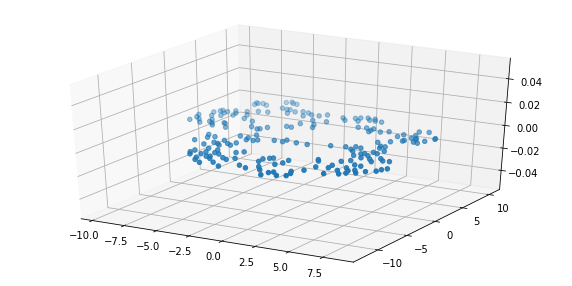

In [67]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#y_pred = y_pred.astype('int')
fig = plt.figure(figsize=(10,5))
tsne = fig.add_subplot(111, projection='3d')
tsne.scatter(*zip(*view))
plt.show()


In [68]:
import math
import torch.nn as nn

##Defining customized loss function
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient


##Defining custom linear layer
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = torch.rand(input_dim, num_hidden) * math.sqrt(2. / input_dim)
    self.bias = torch.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = torch.matmul(x, self.weights) + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = torch.matmul(self.x.T, gradient)
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = torch.matmul(gradient, self.weights.T)
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient


##Defining non - linear activation function reLu
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = torch.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient


##Defining the model class
class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super().__init__()
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 2)
  
  def forward(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2

  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

##Calculating the loss 
loss = MSE()
model = TorchModel(d, 4)
x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(3.0891)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [69]:
def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

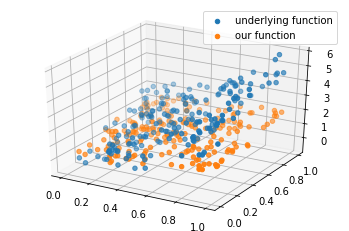

In [70]:
plot_3d(x, y_true, model(x_tensor).detach())

In [71]:

loss = MSE()
model = TorchModel(d, 10)
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss.backward()
model.backward(loss_gradient)
model.update(0.01)
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(2.5560)
tensor(2.4648)


Training our model

In [72]:
from typing import Callable

def fit(x, y, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.01, num_epochs=70)

Epoch 0, loss 2.4647886753082275
Epoch 1, loss 2.3918027877807617
Epoch 2, loss 2.3332064151763916
Epoch 3, loss 2.2858011722564697
Epoch 4, loss 2.2469892501831055
Epoch 5, loss 2.2147016525268555
Epoch 6, loss 2.187321424484253
Epoch 7, loss 2.163602828979492
Epoch 8, loss 2.142599582672119
Epoch 9, loss 2.123599052429199
Epoch 10, loss 2.106071710586548
Epoch 11, loss 2.0896246433258057
Epoch 12, loss 2.0739684104919434
Epoch 13, loss 2.058891773223877
Epoch 14, loss 2.044238567352295
Epoch 15, loss 2.029895782470703
Epoch 16, loss 2.015779972076416
Epoch 17, loss 2.0018301010131836
Epoch 18, loss 1.9880017042160034
Epoch 19, loss 1.9742611646652222
Epoch 20, loss 1.9605841636657715
Epoch 21, loss 1.9469516277313232
Epoch 22, loss 1.933349609375
Epoch 23, loss 1.919767141342163
Epoch 24, loss 1.9061959981918335
Epoch 25, loss 1.8926293849945068
Epoch 26, loss 1.8790619373321533
Epoch 27, loss 1.8654890060424805
Epoch 28, loss 1.8519073724746704
Epoch 29, loss 1.8383136987686157
Epoc

Visualizing after training using *TSNE*

In [73]:
##Function for tsne plot visualization
def tsne_plot(view, y, y_pred=None):
  fig = plt.figure()
  tsne = fig.add_subplot(111, projection='3d')
  tsne.scatter(view[:, 0], view[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    tsne.scatter(view[:, 0], view[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

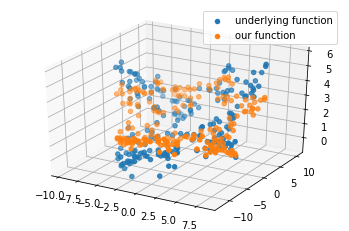

In [74]:
tsne_plot(view, y_true, model(x_tensor).detach())

After Training the data is almost overlapping